This notebook is an attempt to explore Iris dataset and create some meaningful visuals as we go along to understand the data in depth. I will also apply some basic ML classification models and compute the accuracy score for each.

In [370]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

Iris.csv
database.sqlite



In [371]:
data = pd.read_csv("../input/Iris.csv")
data_copy = data
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [372]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 7.1+ KB


In [373]:
# Check if any duplicate rows are present in the dataset. 
# Checking with Id as it must be unique
data['Id'].duplicated().any()

False

This is the beauty of Iris data set and why it is used by beginners to learn data analysis and even machine learning. We do not have any missing values or duplicated data so we can focus our energy on understanding the data and apply different ML algorithms for classification. So let's continue to understand the different variables (columns) in our dataset

Text(0.5,1,'Distribution of PetalWidthCm')

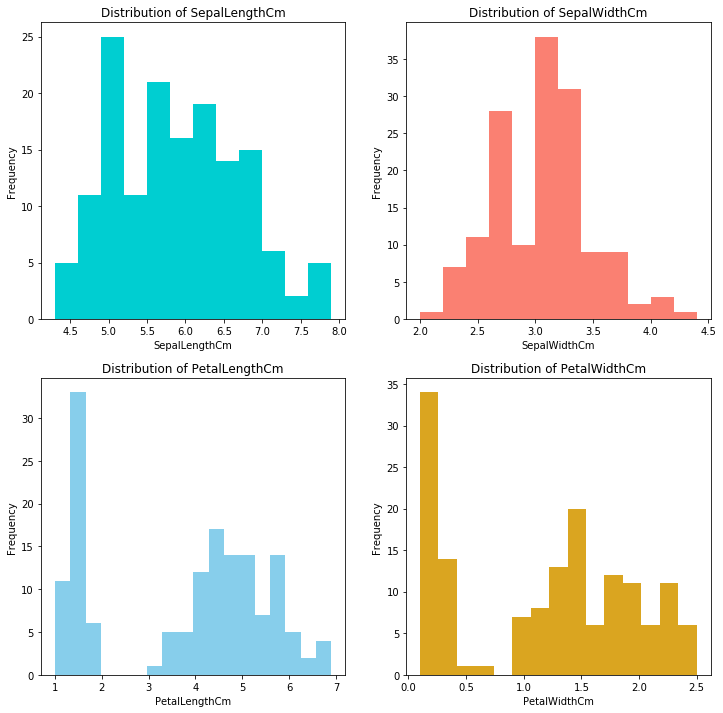

In [374]:
plt.figure(figsize=[12,12])

# First subplot showing the diamond carat weight distribution
plt.subplot(221)
plt.hist(data['SepalLengthCm'],bins=12,color='darkturquoise')
plt.xlabel('SepalLengthCm')
plt.ylabel('Frequency')
plt.title('Distribution of SepalLengthCm')

# Second subplot showing the diamond depth distribution
plt.subplot(222)
plt.hist(data['SepalWidthCm'],bins=12,color='salmon')
plt.xlabel('SepalWidthCm')
plt.ylabel('Frequency')
plt.title('Distribution of SepalWidthCm')

# Third subplot showing the diamond price distribution
plt.subplot(223)
plt.hist(data['PetalLengthCm'],bins=18,color='skyblue')
plt.xlabel('PetalLengthCm')
plt.ylabel('Frequency')
plt.title('Distribution of PetalLengthCm')

# Fourth subplot showing the diamond price distribution
plt.subplot(224)
plt.hist(data['PetalWidthCm'],bins=15,color='goldenrod')
plt.xlabel('PetalWidthCm')
plt.ylabel('Frequency')
plt.title('Distribution of PetalWidthCm')

SepalLengthCm: This looks like a normal distrbution but it is clearly visible that there are some spikes especially a high concentration at SepalLength = 5cm which makes it skightly right skewed. It might be interesting to check the central tendency.

SepalWidthCm: This is close to a normal distribution barring the one dip at ~2.8. 

PetalLengthCm: This is a tricky column because the data is discontinuous. Moreover, it seems the two groups of data are normal. At this point, I'm wondering if the two sets corresspond to the two categories of species. If so, the machine learning part for this feature should result in a great accuracy. We will come back to this part later but for now let's compute the overall central tendency.

PetalWidthCm: Similar to above column, this column data is also discontinuous. So in all petal data (both width and height) are discontinuous and might turn out to be very useful in classification algorithm. Out of curiosity, let's go one step ahead right now and check the range for each species for these two columns and confirm if our hypothesis is correct.

In [375]:
central_tendency_SepalLengthCm = {'mean': round(data['SepalLengthCm'].mean(),4), 'median': data['SepalLengthCm'].median(), 'mode': data['SepalLengthCm'].mode()}
central_tendency_SepalLengthCm

{'mean': 5.8433, 'median': 5.8, 'mode': 0    5.0
 dtype: float64}

In [376]:
central_tendency_SepalWidthCm = {'mean': round(data['SepalWidthCm'].mean(),4), 'median': data['SepalWidthCm'].median(), 'mode': data['SepalWidthCm'].mode()}
central_tendency_SepalWidthCm

{'mean': 3.054, 'median': 3.0, 'mode': 0    3.0
 dtype: float64}

In [377]:
central_tendency_PetalLengthCm = {'mean': round(data['PetalLengthCm'].mean(), 4), 'median': data['PetalLengthCm'].median(), 'mode': data['PetalLengthCm'].mode()}
central_tendency_PetalLengthCm

{'mean': 3.7587, 'median': 4.35, 'mode': 0    1.5
 dtype: float64}

In [378]:
data.groupby(['Species']).size().reset_index(name='counts')

,Species,counts
0,Iris-setosa,50
1,Iris-versicolor,50
2,Iris-virginica,50


In [379]:
data['Species'].loc[data['PetalLengthCm'] < 2.5].unique()

array(['Iris-setosa'], dtype=object)

In [380]:
data['Species'].loc[data['PetalLengthCm'] < 2.5].count()

50

In [381]:
data['Species'].loc[data['PetalLengthCm'] > 2.5].unique()

array(['Iris-versicolor', 'Iris-virginica'], dtype=object)

In [382]:
data['Species'].loc[data['PetalWidthCm'] < 0.8].unique()

array(['Iris-setosa'], dtype=object)

In [383]:
data['Species'].loc[data['PetalWidthCm'] < 0.8].count()

50

In [384]:
data['Species'].loc[data['PetalWidthCm'] > 0.8].unique()

array(['Iris-versicolor', 'Iris-virginica'], dtype=object)

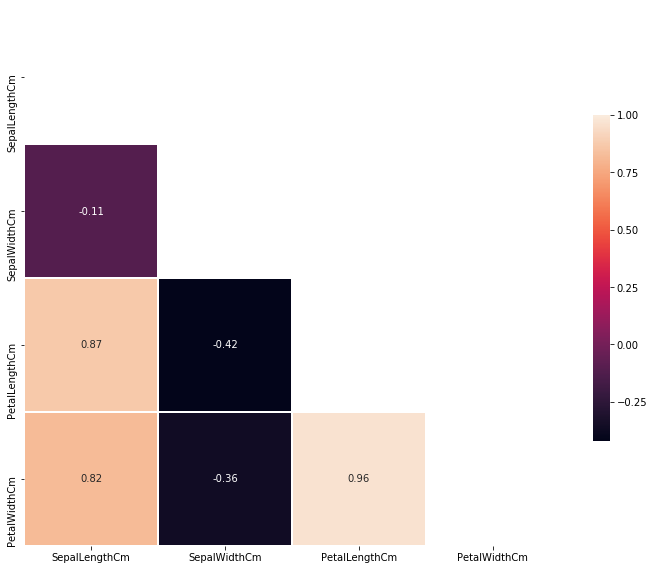

In [385]:
corr = data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

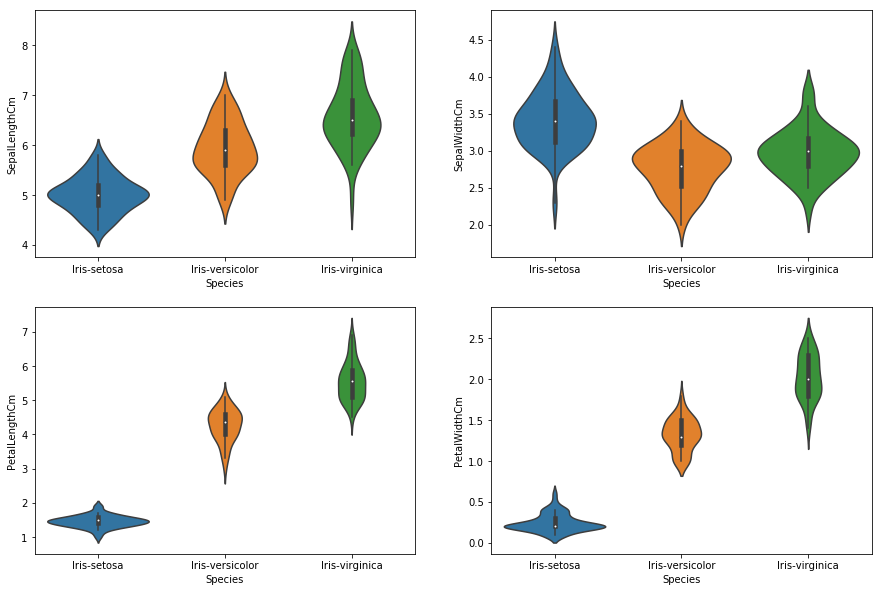

In [386]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.violinplot(x='Species',y='SepalLengthCm',data=data)
plt.subplot(2,2,2)
sns.violinplot(x='Species',y='SepalWidthCm',data=data)
plt.subplot(2,2,3)
sns.violinplot(x='Species',y='PetalLengthCm',data=data)
plt.subplot(2,2,4)
sns.violinplot(x='Species',y='PetalWidthCm',data=data)

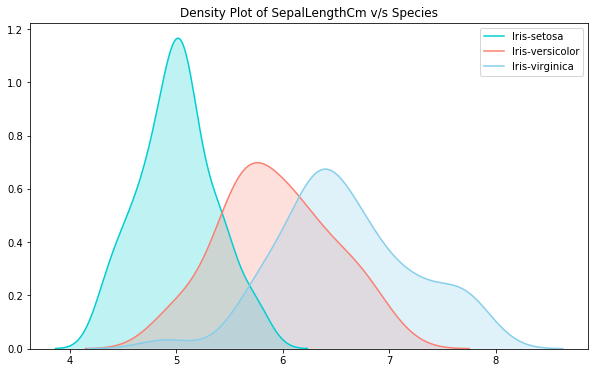

In [387]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["SepalLengthCm"][data.Species == 'Iris-setosa'], color="darkturquoise", shade=True)
sns.kdeplot(data["SepalLengthCm"][data.Species == 'Iris-versicolor'], color="salmon", shade=True)
sns.kdeplot(data["SepalLengthCm"][data.Species == 'Iris-virginica'], color="skyblue", shade=True)
#plt.xlim(-20,300)
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('Density Plot of SepalLengthCm v/s Species')
plt.show()

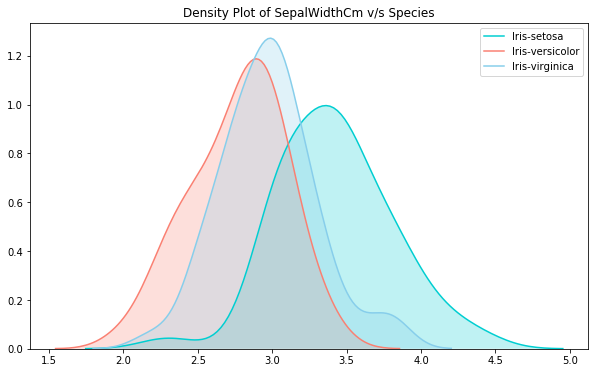

In [388]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["SepalWidthCm"][data.Species == 'Iris-setosa'], color="darkturquoise", shade=True)
sns.kdeplot(data["SepalWidthCm"][data.Species == 'Iris-versicolor'], color="salmon", shade=True)
sns.kdeplot(data["SepalWidthCm"][data.Species == 'Iris-virginica'], color="skyblue", shade=True)
#plt.xlim(-20,300)
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('Density Plot of SepalWidthCm v/s Species')
plt.show()

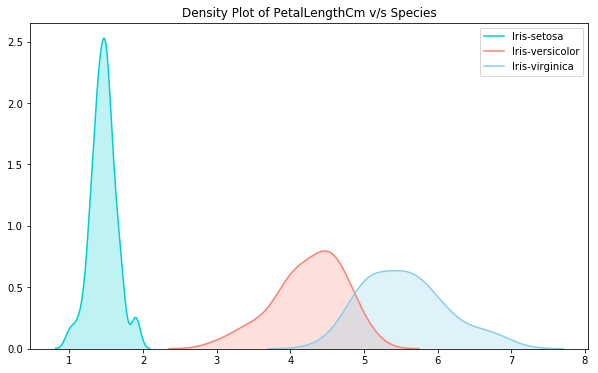

In [389]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["PetalLengthCm"][data.Species == 'Iris-setosa'], color="darkturquoise", shade=True)
sns.kdeplot(data["PetalLengthCm"][data.Species == 'Iris-versicolor'], color="salmon", shade=True)
sns.kdeplot(data["PetalLengthCm"][data.Species == 'Iris-virginica'], color="skyblue", shade=True)
#plt.xlim(-20,300)
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('Density Plot of PetalLengthCm v/s Species')
plt.show()

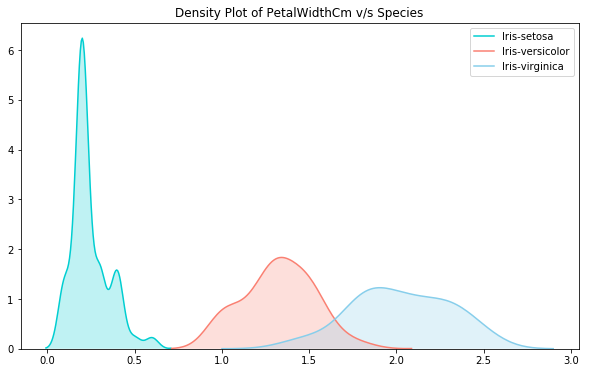

In [390]:
plt.figure(figsize=(10,6))
sns.kdeplot(data["PetalWidthCm"][data.Species == 'Iris-setosa'], color="darkturquoise", shade=True)
sns.kdeplot(data["PetalWidthCm"][data.Species == 'Iris-versicolor'], color="salmon", shade=True)
sns.kdeplot(data["PetalWidthCm"][data.Species == 'Iris-virginica'], color="skyblue", shade=True)
#plt.xlim(-20,300)
plt.legend(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])
plt.title('Density Plot of PetalWidthCm v/s Species')
plt.show()

In [391]:
# data_final = pd.get_dummies(data, columns=['Species'])
# data_final.head()

In [392]:
X = data.drop(['Species', 'Id'],1)
y = data['Species']

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [394]:
clf = GaussianNB() 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.966666666667


In [395]:
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

1.0


In [396]:
clf = tree.DecisionTreeClassifier() 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.966666666667


In [397]:
clf = svm.SVC(kernel = 'rbf', C = 10) 
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.966666666667


In [398]:
clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.966666666667


([<matplotlib.axis.XTick at 0x7f681a7d47f0>,
 <a list of 10 Text xticklabel objects>)

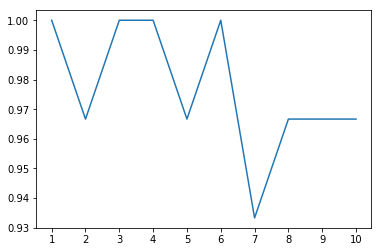

In [399]:
l=list(range(1,11))
a=pd.Series()
x=[1,2,3,4,5,6,7,8,9,10]
for i in l:
    clf=KNeighborsClassifier(n_neighbors=i) 
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    a=a.append(pd.Series(accuracy_score(pred, y_test)))
plt.plot(l, a)
plt.xticks(x)

In [406]:
clf = KNeighborsClassifier(n_neighbors = 4)
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

1.0


So, the above graph indicates that accuracy is 100% with KNN model in this case if the hyperparameter nearest neighbours (n_neighbours) is set to 1,3,4 or 6. So when I optimized this model by setting this parameter to 4 and I get an accuracy of 100% as reflected in graph. Target achieved, classification successful!

Let's see now how the decision boundaries look like

In [432]:
from sklearn import datasets
iris = datasets.load_iris()
X_mod = iris.data[:, [2, 3]]
y = iris.target

In [433]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y, test_size = 0.2)

In [449]:
clf = KNeighborsClassifier()
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(pred, y_test)
print(accuracy)

0.966666666667


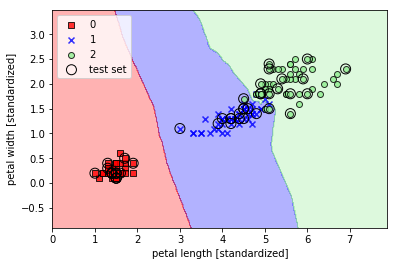

In [445]:
def plot_decision_regions(X_mod, y, clf, test_idx=None, resolution=0.02):
       # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X_mod[:, 0].min() - 1, X_mod[:, 0].max() + 1
    x2_min, x2_max = X_mod[:, 1].min() - 1, X_mod[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = clf.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
       plt.scatter(x=X_mod[y == cl, 0], y=X_mod[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')
   # highlight test samples
    if test_idx:
       # plot all samples
       X_test, y_test = X_mod[test_idx, :], y[test_idx]
       plt.scatter(X_test[:, 0], X_test[:, 1],
                   c='', edgecolor='black', alpha=1.0,
                   linewidth=1, marker='o',
                   s=100, label='test set')

X_combined_std = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_mod=X_combined_std, y=y_combined, clf=clf,test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.show()